In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black
import calpred
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import statsmodels.api as sm
import os
import subprocess
import matplotlib

We simulate different disease architecture

In [2]:
def format_df(prs, y):
    df = {"PGS": [], "E": [], "y": []}
    for i in range(2):
        df["PGS"].extend(prs[:, i])
        df["E"].extend([i] * len(prs))
        df["y"].extend(y[:, i])
    df = pd.DataFrame(df)
    df["PGSxE"] = df["PGS"] * df["E"]

    fit = calpred.fit(y=df["y"], x=df[["PGS", "PGSxE"]], z=df[["E"]])
    # mean_coef, mean_se, sd_coef, sd_se = fit.mean_coef, fit.mean_se, fit.sd_coef, fit.sd_se
    df["predmean"], df["predsd"] = calpred.predict(
        x=df[["PGS", "PGSxE"]], z=df[["E"]], model_fit=fit
    )
    return df


def plot_df(df, figsize=(5, 2.7), out_prefix=None):

    fig, axes = plt.subplots(
        figsize=figsize, dpi=150, ncols=2, sharex=True, sharey=True
    )
    for i in range(2):
        sub_df = df[df["E"] == i]
        ax = axes[i]
        calpred.plot_scatter_calibration(
            x=sub_df["PGS"], y=sub_df["y"], ax=ax, downsample=0.2
        )
        ax.set_xlabel("PGS")
        ax.set_title(f"Context={i + 1}")
        ax.legend(loc="upper left", fontsize=7)
        ax.set_ylim(-4, 4)

    axes[0].set_ylabel("Phenotype")
    fig.tight_layout()

    if out_prefix:
        fig.savefig(out_prefix + ".pgs.png", bbox_inches="tight")

    fig, axes = plt.subplots(
        figsize=figsize, dpi=150, ncols=2, sharex=True, sharey=True
    )
    for i in range(2):
        sub_df = df[df["E"] == i].reset_index(drop=True)
        ax = axes[i]
        calpred.plot_scatter_calibration(
            x=sub_df["predmean"], y=sub_df["y"], ax=ax, downsample=0.2
        )
        ax.set_xlabel("Calibrated PGS")
        ax.set_title(f"Context={i + 1}")

        idx = sub_df.sort_values("PGS").index[int(len(sub_df) * 0.95)]
        x, ysd = sub_df["predmean"].values[idx], sub_df["predsd"].values[idx]
        coverage = np.mean(
            (sub_df["y"] - sub_df["predmean"]).abs() < sub_df["predsd"] * 1.645
        )
        ax.errorbar(
            x=[x],
            y=[x],
            yerr=ysd * 1.645,
            fmt=".",
            markersize=4,
            color="red",
            capsize=3,
            linewidth=1,
            label=f"SD={ysd:.2f}"
            # label=f"ysd={ysd:.2f} (coverage={coverage*100:.1f}%)",
        )
        ax.legend(loc="upper left", fontsize=6)
        ax.set_xlim(-2.5, 2.5)
        ax.set_ylim(-4, 4)

    axes[0].set_ylabel("Phenotype")

    fig.tight_layout()
    if out_prefix:
        fig.savefig(out_prefix + ".calpred.png", bbox_inches="tight")

# Scenario 1: imperfect genetic correlation

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 217.64it/s]


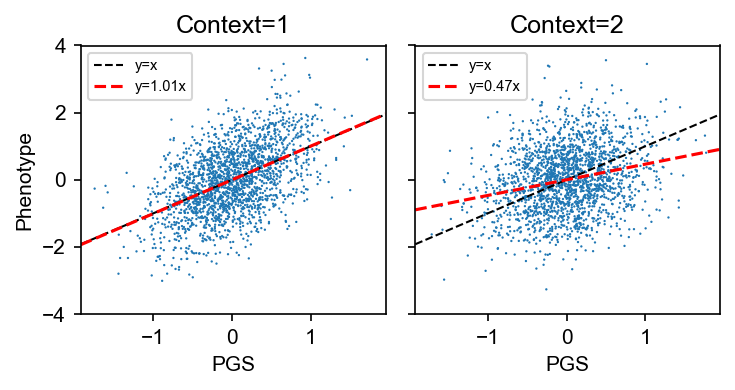

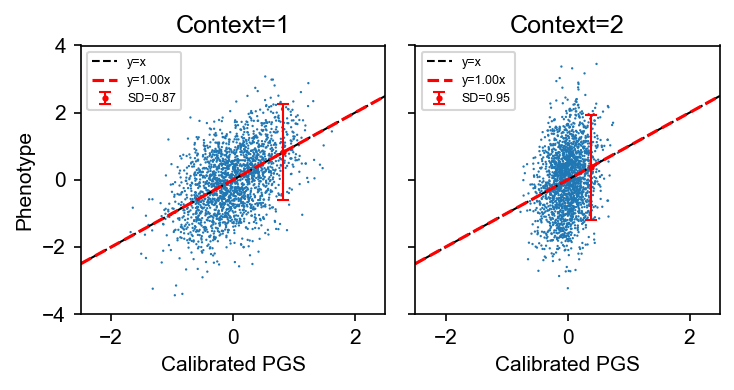

In [3]:
np.random.seed(1234)
rep = 0

ymat, prsmat, gmat, emat, betamat, betaprsmat = calpred.simulate_gxe(
    scenario=1, hsq=0.5, rg=0.5, n_rep=10
)
y, prs, g = ymat[:, :, rep], prsmat[:, :, rep], gmat[:, :, rep]
df = format_df(prs, y)
plot_df(df, out_prefix="simulate_quant_traits/scenario1")

# Scenario 2

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 413.56it/s]


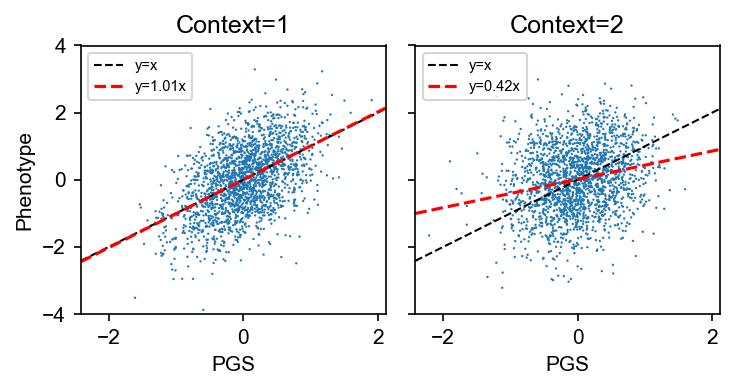

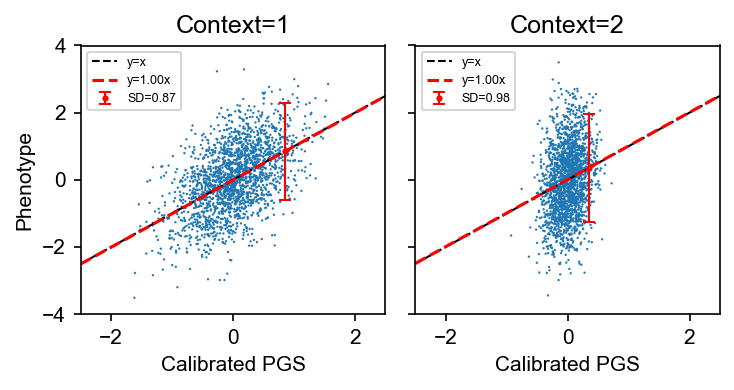

In [4]:
ymat, prsmat, gmat, emat, beta, betaprs = calpred.simulate_gxe(
    scenario=2, hsq1=0.5, hsq2=0.1
)

y, prs, g = ymat[:, :, rep], prsmat[:, :, rep], gmat[:, :, rep]

df = format_df(prs, y)
plot_df(df, out_prefix="simulate_quant_traits/scenario2")

# Scenario 3

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 250.11it/s]


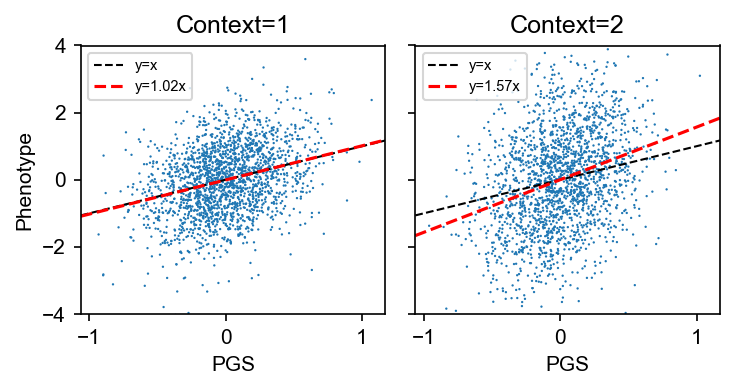

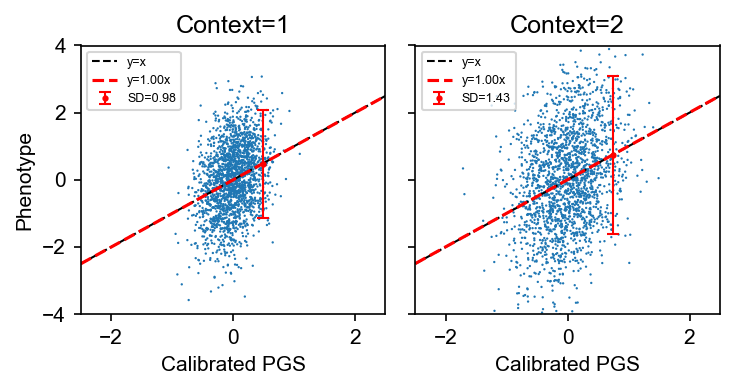

In [5]:
ymat, prsmat, gmat, emat, beta, betaprs = calpred.simulate_gxe(
    scenario=3, hsq=0.25, prop_amp=1.5
)

y, prs, g = ymat[:, :, rep], prsmat[:, :, rep], gmat[:, :, rep]

df = format_df(prs, y)
plot_df(df, out_prefix="simulate_quant_traits/scenario3")

# Main figure
1. Genetic correlation = 0.75
2. hsq1 = 0.5, hsq2 = 0.4

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 233.74it/s]


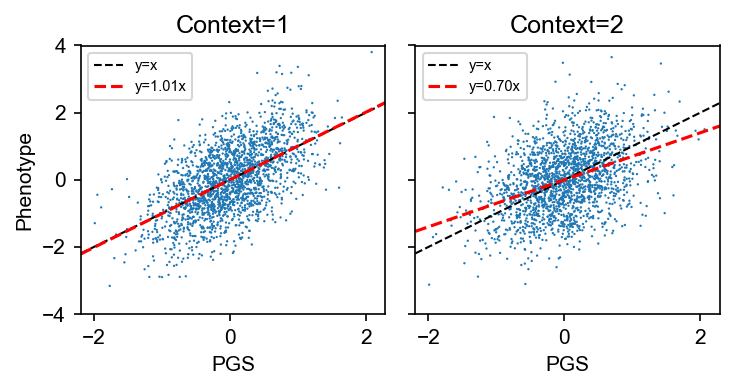

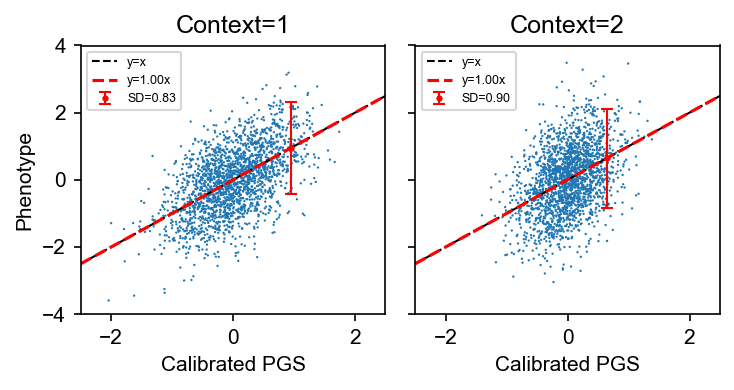

In [6]:
np.random.seed(1234)
rep = 0

ymat, prsmat, gmat, emat, betamat, betaprsmat = calpred.simulate_gxe3(
    var_g1=0.6, var_g2=0.5, var_e1=0.4, var_e2=0.5, rg=0.8, n_rep=10
)
y, prs, g = ymat[:, :, rep], prsmat[:, :, rep], gmat[:, :, rep]
df = format_df(prs, y)
plot_df(df, out_prefix="simulate_quant_traits/main")